# Третья лабораторная работа
## Обучение моделей классификации
## Цель задания
Изучить основные методы классификации в машинном обучении, освоить
практические навыки построения, обучения и оценки моделей
классификации для решения задач распознавания категорий (дискретных
классов).

## Выполнение

### 1. Выбор датасета
Выберите датасет на сайте kaggle.com, подходящий для решения задач
классификации (предсказания категориальных меток), если вариант с 1
ЛР работы подходит для данной задачи, можно оставить его. Если датасет
из предыдущих лабораторных работ можно адаптировать к задаче
классификации (например, преобразовать целевую переменную в
категории), допускается его использование. 
    
https://www.kaggle.com/datasets/pranavkapratwar/fruit-classification



## 2. Предобработка данных

### Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


### Анализ пропущенных значение и их обработка

In [2]:
dataset = pd.read_csv("./data/fruit_classification_dataset.csv")

def process_null_val():
    null_val_count = dataset.isnull().sum()

    print("Количество пропусков")
    print(null_val_count)

    if len(null_val_count) > 0:
        return dataset.dropna()
    else:
        return dataset


def process_duplicate_rows(df, target_col='fruit_name'):
    feature_cols = [c for c in df.columns if c != target_col]
    df_clean = df.drop_duplicates(subset=feature_cols, keep='first').reset_index(drop=True)
    print("До:", len(df), "После:", len(df_clean), "удалено:", len(df)-len(df_clean))
    return df_clean
    
process_null_val()
dataset = process_duplicate_rows(dataset)

Количество пропусков
size (cm)        0
shape            0
weight (g)       0
avg_price (₹)    0
color            0
taste            0
fruit_name       0
dtype: int64
До: 10000 После: 9754 удалено: 246


### Обработка выбросов


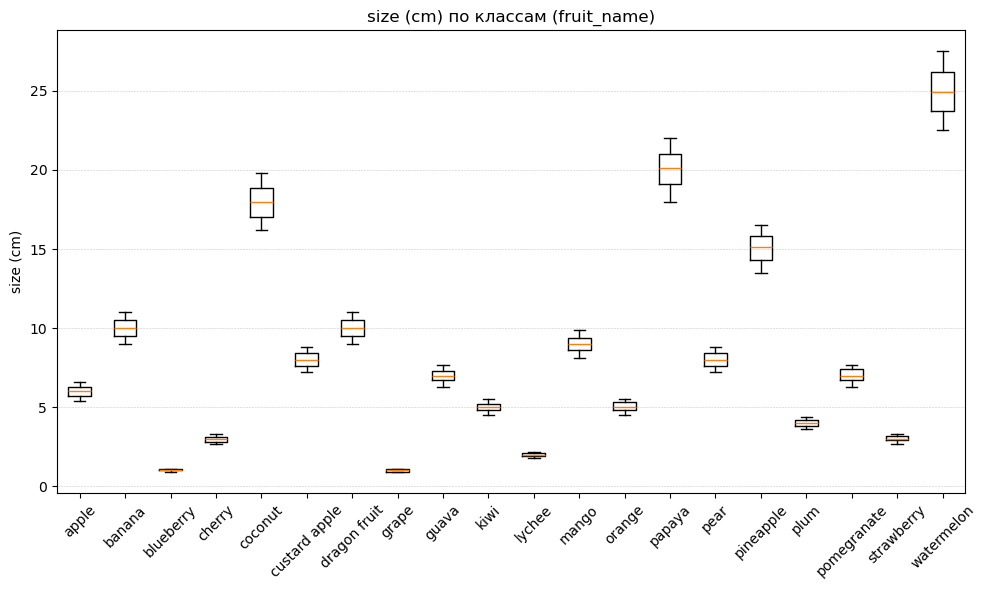

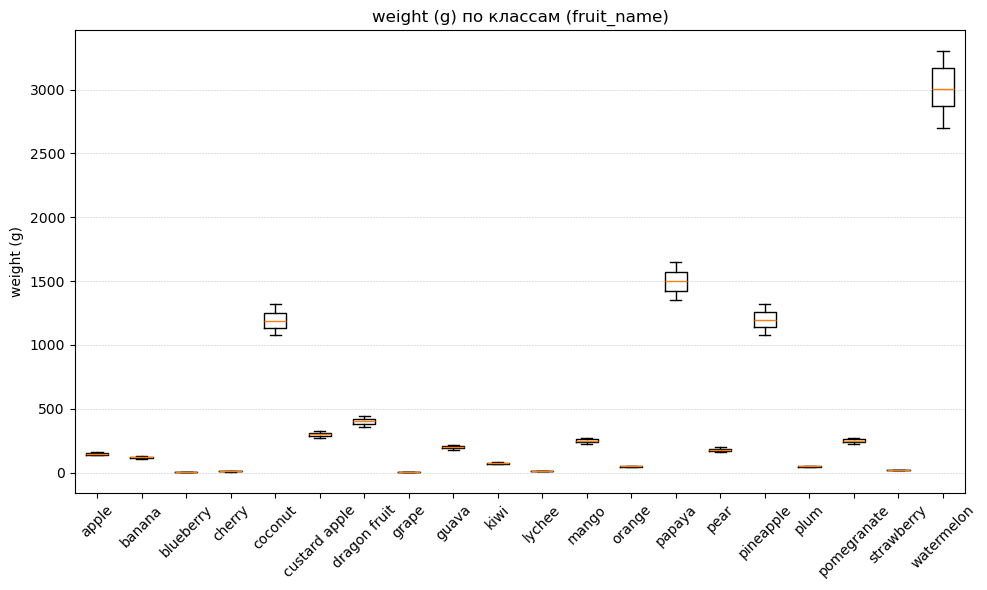

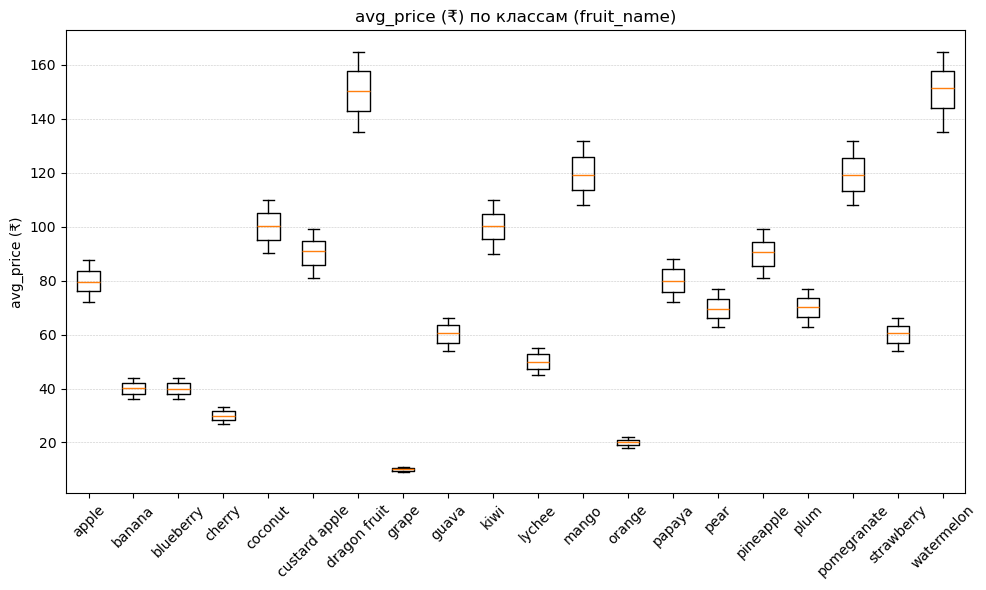

Class="apple": удалено 0 строк, осталось 492
Class="banana": удалено 0 строк, осталось 502
Class="blueberry": удалено 0 строк, осталось 443
Class="cherry": удалено 0 строк, осталось 462
Class="coconut": удалено 0 строк, осталось 502
Class="custard apple": удалено 0 строк, осталось 516
Class="dragon fruit": удалено 0 строк, осталось 496
Class="grape": удалено 0 строк, осталось 346
Class="guava": удалено 0 строк, осталось 481
Class="kiwi": удалено 0 строк, осталось 506
Class="lychee": удалено 0 строк, осталось 495
Class="mango": удалено 0 строк, осталось 500
Class="orange": удалено 0 строк, осталось 484
Class="papaya": удалено 0 строк, осталось 509
Class="pear": удалено 0 строк, осталось 534
Class="pineapple": удалено 0 строк, осталось 533
Class="plum": удалено 0 строк, осталось 489
Class="pomegranate": удалено 0 строк, осталось 534
Class="strawberry": удалено 0 строк, осталось 432
Class="watermelon": удалено 0 строк, осталось 498
Итого: до = 9754 строк, после = 9754 строк, удалено = 0


In [3]:
def make_exhaust_boxplots(df, cols=None, class_col='fruit_name', per_class=True, figsize=(10,6), showfliers=True):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if class_col in cols:
        cols = [c for c in cols if c != class_col]

    if per_class and class_col in df.columns:
        classes = sorted(df[class_col].dropna().unique().tolist())
        for col in cols:
            data = []
            labels = []
            for cls in classes:
                arr = df.loc[df[class_col] == cls, col].dropna().values
                if arr.size > 0:
                    data.append(arr)
                    labels.append(cls)
            if not data:
                continue
            plt.figure(figsize=figsize)
            plt.boxplot(data, showfliers=showfliers)
            plt.title(f'{col} по классам ({class_col})')
            plt.ylabel(col)
            plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=45)
            plt.grid(axis='y', linestyle='--', linewidth=0.4, alpha=0.7)
            plt.tight_layout()
            plt.show()
    else:
        for col in cols:
            arr = df[col].dropna().values
            if arr.size == 0:
                continue
            plt.figure(figsize=figsize)
            plt.boxplot(arr, showfliers=showfliers)
            plt.title(col)
            plt.ylabel(col)
            plt.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
            plt.tight_layout()
            plt.show()


def per_class_outlier_report(df, cols=None, class_col='fruit_name', iqr_multiplier=1.5, min_samples=5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if class_col in cols:
        cols = [c for c in cols if c != class_col]

    rows = []
    for cls in sorted(df[class_col].dropna().unique()):
        cls_df = df[df[class_col] == cls]
        n = len(cls_df)
        for col in cols:
            series = cls_df[col].dropna()
            if series.empty:
                rows.append((cls, col, n, np.nan, np.nan, np.nan, np.nan, np.nan))
                continue
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_multiplier * IQR
            upper = Q3 + iqr_multiplier * IQR
            out_count = int(((series < lower) | (series > upper)).sum())
            rows.append((cls, col, n, float(Q1), float(Q3), float(IQR), float(lower), float(upper), out_count))
    report = pd.DataFrame(rows, columns=[class_col, 'column', 'n_samples', 'Q1', 'Q3', 'IQR', 'lower', 'upper', 'outliers'])
    return report


def exhaust_process(df,
                    cols=None,
                    class_col='fruit_name',
                    method='iqr',            
                    iqr_multiplier=1.5,
                    min_samples=15,
                    contamination=0.02,       
                    sequential_within_class=True,
                    verbose=True):

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if class_col in cols:
        cols = [c for c in cols if c != class_col]

    usable_cols = []
    for c in cols:
        if c not in df.columns:
            continue
        uniq = df[c].dropna().unique()
        if len(uniq) <= 1:
            if verbose:
                print(f'Колонка "{c}" пропущена (<=1 уникальное значение).')
            continue
        usable_cols.append(c)
    cols = usable_cols
    if not cols:
        if verbose:
            print("Нет числовых колонок для фильтрации.")
        return df.copy(), pd.DataFrame(columns=[class_col, 'removed', 'remaining'])

    df_filtered = df.copy()
    report_rows = []

    classes = sorted(df[class_col].dropna().unique().tolist())
    for cls in classes:
        idx_cls = df_filtered[df_filtered[class_col] == cls].index
        n_before = len(idx_cls)
        if n_before == 0:
            report_rows.append((cls, 0, 0))
            continue
        if n_before < min_samples:
            if verbose:
                print(f'Class="{cls}": мало примеров ({n_before}<{min_samples}), пропускаю per-class фильтрацию.')
            report_rows.append((cls, 0, n_before))
            continue

        to_drop = pd.Index([])

        if method in ('iqr', 'combined'):
            if sequential_within_class:
                keep = pd.Series(True, index=idx_cls)
                for col in cols:
                    series = df_filtered.loc[keep[keep].index, col].dropna()
                    if series.empty:
                        continue
                    Q1 = series.quantile(0.25)
                    Q3 = series.quantile(0.75)
                    IQR = Q3 - Q1
                    lower = Q1 - iqr_multiplier * IQR
                    upper = Q3 + iqr_multiplier * IQR
                    idx_current = keep[keep].index
                    mask_col = (df_filtered.loc[idx_current, col] >= lower) & (df_filtered.loc[idx_current, col] <= upper)
                    drop_idx = idx_current[~mask_col]
                    if drop_idx.size:
                        keep.loc[drop_idx] = False
                to_drop = to_drop.union(keep[~keep].index)
            else:
                masks = []
                for col in cols:
                    series = df_filtered.loc[idx_cls, col].dropna()
                    if series.empty:
                        masks.append(pd.Series(True, index=idx_cls))
                        continue
                    Q1 = series.quantile(0.25)
                    Q3 = series.quantile(0.75)
                    IQR = Q3 - Q1
                    lower = Q1 - iqr_multiplier * IQR
                    upper = Q3 + iqr_multiplier * IQR
                    masks.append((df_filtered.loc[idx_cls, col] >= lower) & (df_filtered.loc[idx_cls, col] <= upper))
                if masks:
                    combined = np.logical_and.reduce([m.reindex(idx_cls, fill_value=True) for m in masks])
                    to_drop = to_drop.union(idx_cls.difference(idx_cls[combined]))

        if method in ('isolation_forest', 'combined'):
            remaining_idx = idx_cls.difference(to_drop)
            if len(remaining_idx) >= max(min_samples, 10):
                X = df_filtered.loc[remaining_idx, cols].fillna(df_filtered.loc[remaining_idx, cols].median())
                scaler = StandardScaler()
                Xs = scaler.fit_transform(X)
                iso = IsolationForest(contamination=contamination, random_state=42)
                preds = iso.fit_predict(Xs)
                drop_iso = remaining_idx[preds == -1]
                to_drop = to_drop.union(drop_iso)

        removed = len(to_drop)
        if removed > 0:
            df_filtered = df_filtered.drop(index=to_drop)
        report_rows.append((cls, int(removed), int(df_filtered[df_filtered[class_col] == cls].shape[0])))
        if verbose:
            print(f'Class="{cls}": удалено {removed} строк, осталось {df_filtered[df_filtered[class_col]==cls].shape[0]}')

    report = pd.DataFrame(report_rows, columns=[class_col, 'removed', 'remaining'])
    if verbose:
        total_before = df.shape[0]
        total_after = df_filtered.shape[0]
        print(f'Итого: до = {total_before} строк, после = {total_after} строк, удалено = {total_before - total_after}')
    return df_filtered, report

make_exhaust_boxplots(dataset, per_class=True) 

dataset = exhaust_process(dataset,
                                cols=['size (cm)','weight (g)','avg_price (₹)'],
                                class_col='fruit_name',
                                iqr_multiplier=1.5,
                                min_samples=20,
                                sequential_within_class=True,
                                verbose=True)[0]


### Обработка типов данных

In [4]:
def to_float(series, params=None, return_params=False):
    s = pd.Series(series)
    s = s.astype(str).str.strip()
    s = s.str.replace(',', '.', regex=False)
    s = s.str.replace(r'[^\d\.\-]', '', regex=True)
    s = s.replace('', np.nan)
    s = pd.to_numeric(s, errors='coerce').astype('float')

    if params is None:
        mean = s.mean(skipna=True)
        std = s.std(skipna=True)
        if pd.isna(std) or std == 0:
            std = 1.0
        params = {'mean': float(mean) if not pd.isna(mean) else 0.0, 'std': float(std)}
    mean = params.get('mean', 0.0)
    std = params.get('std', 1.0)
    if std == 0:
        std = 1.0
    s_norm = (s - mean) / std

    if return_params:
        return s_norm, params
    return s_norm

def to_str(series):
    return series.where(series.isna(), series.astype(str).str.strip())

def one_hot_fruit(df, class_col='fruit_name', top_k=None, keep_original=False, prefix='fruit'):
    if class_col not in df.columns:
        return df.copy()
    s = df[class_col].astype(str).str.strip()
    if top_k is not None:
        top = s.value_counts().index[:top_k]
        s = s.where(s.isin(top), other='other')
    dummies = pd.get_dummies(s, prefix=prefix)
    out = pd.concat([df.copy(), dummies], axis=1)
    if not keep_original:
        out = out.drop(columns=[class_col])
    return out

def transform_dataset(df,
                      float_cols=('size (cm)', 'weight (g)', 'avg_price (₹)'),
                      str_cols=('shape', 'color', 'taste'),
                      class_col='fruit_name',
                      top_k_fruits=None,
                      keep_original_class=False,
                      prefix='fruit',
                      categorical_encoding='onehot'):

    df = df.copy()
    norm_params = {}
    for c in float_cols:
        if c in df.columns:
            df[c], params = to_float(df[c], params=None, return_params=True)
            norm_params[c] = params

    if categorical_encoding == 'onehot':
        for c in str_cols:
            if c in df.columns:
                s = to_str(df[c]).replace({'nan': np.nan})
                dummies = pd.get_dummies(s, prefix=c, dummy_na=True)
                df = pd.concat([df.drop(columns=[c]), dummies], axis=1)
    elif categorical_encoding == 'label':
        for c in str_cols:
            if c in df.columns:
                s = to_str(df[c]).replace({'nan': np.nan})
                cat = pd.Categorical(s)
                codes = pd.Series(cat.codes, index=s.index).replace({-1: np.nan})
                df[c] = codes.astype(float)
    else:
        raise ValueError("categorical_encoding must be 'onehot' or 'label'")

    df = one_hot_fruit(df, class_col=class_col, top_k=top_k_fruits, keep_original=keep_original_class, prefix=prefix)
    return df, norm_params


dataset, norm_params = transform_dataset(dataset)

### Разделение набора данных на обучающий и тестовый


In [8]:
def split_dataset_after_onehot(dataset, onehot_prefix='fruit_', target_col='fruit_name',
                                test_size=0.2, random_state=42, shuffle=True):
    df = dataset.copy()
    if target_col in df.columns:
        y = df[target_col].astype(object)
        X = df.drop(columns=[target_col], errors='ignore')
    else:
        onehot_cols = [c for c in df.columns if c.startswith(onehot_prefix)]
        if not onehot_cols:
            raise ValueError(f"Нет колонки '{target_col}' и не найдены столбцы с префиксом '{onehot_prefix}'")
        sums = (df[onehot_cols] > 0.5).sum(axis=1)
        idxmax = df[onehot_cols].idxmax(axis=1).str[len(onehot_prefix):]
        y = idxmax.where(sums > 0, other=np.nan).astype(object)
        X = df.drop(columns=onehot_cols, errors='ignore')

    stratify_arg = None
    if not y.isna().any():
        if (y.dtype == 'O') or (y.dtype.name == 'category') or (y.nunique() <= 20):
            stratify_arg = y

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle, stratify=stratify_arg
    )

    print(f"Train: {len(X_train)} rows, Test: {len(X_test)} rows")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)


print(f"Train: {len(X_train)} rows, Test: {len(X_test)} rows")

ValueError: not enough values to unpack (expected 4, got 2)

## 3. Построение и обучение моделей

In [6]:
models = {
    'DecisionTree': Pipeline([('clf', DecisionTreeClassifier(random_state=42))]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))]),
    'LogisticRegression': Pipeline([('scaler', StandardScaler()),
                                    ('lr', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))]),
    'GaussianNB': Pipeline([('scaler', StandardScaler()), ('gnb', GaussianNB())])
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} fitted")

DecisionTree fitted
KNN fitted
LogisticRegression fitted
GaussianNB fitted


## 4.Оценка результатов моделей

In [7]:
def evaluate_classification_model(model, average=None):
    y_pred = model.predict(X_test)

    try:
        unique_labels = np.unique(y_test)
        n_labels = len(unique_labels)
    except Exception:
        n_labels = 2

    if average is None:
        average = 'binary' if n_labels == 2 else 'weighted'

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=0)
    recall = recall_score(y_test, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=0)

    roc_auc = np.nan
    try:
        if n_labels == 2:
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, probs)
            elif hasattr(model, "decision_function"):
                scores = model.decision_function(X_test)
                roc_auc = roc_auc_score(y_test, scores)
            else:
                roc_auc = np.nan
        else:
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X_test)
                roc_auc = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
            elif hasattr(model, "decision_function"):
                scores = model.decision_function(X_test)
                if getattr(scores, "ndim", 1) == 2:
                    roc_auc = roc_auc_score(y_test, scores, multi_class='ovr', average='macro')
                else:
                    roc_auc = np.nan
            else:
                roc_auc = np.nan
    except Exception:
        roc_auc = np.nan

    return {
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }


def compare_models(models, sort_by='f1', ascending=False, average=None, save_path=None):
    rows = []

    if isinstance(models, dict):
        iterator = models.items()
    else:
        iterator = models

    for name, model in iterator:
        try:
            res = evaluate_classification_model(model, average=average)
        except Exception as e:
            print(f"Error evaluating model {name}: {e}")
            rows.append({'model': name, 'accuracy': np.nan, 'precision': np.nan,
                         'recall': np.nan, 'f1': np.nan, 'roc_auc': np.nan})
            continue

        rows.append({
            'model': name,
            'accuracy': res['accuracy'],
            'precision': res['precision'],
            'recall': res['recall'],
            'f1': res['f1'],
            'roc_auc': res['roc_auc']
        })

    df = pd.DataFrame(rows).set_index('model')

    if sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=ascending)

    df_display = df.copy().round(4)

    if save_path is not None:
        df.to_csv(save_path)
        print(f"Saved comparison to {save_path}")

    print("\nModel comparison (sorted by {}):".format(sort_by))
    print(df_display)

    return df


compare_models(models)


Model comparison (sorted by f1):
                    accuracy  precision  recall   f1  roc_auc
model                                                        
DecisionTree             1.0        1.0     1.0  1.0      1.0
KNN                      1.0        1.0     1.0  1.0      1.0
LogisticRegression       1.0        1.0     1.0  1.0      1.0
GaussianNB               1.0        1.0     1.0  1.0      1.0


,accuracy,precision,recall,f1,roc_auc
model,,,,,
DecisionTree,1.0,1.0,1.0,1.0,1.0
KNN,1.0,1.0,1.0,1.0,1.0
LogisticRegression,1.0,1.0,1.0,1.0,1.0
GaussianNB,1.0,1.0,1.0,1.0,1.0


## 5. Выбор лучшей модели и анализ результатов
Accuracy — доля правильно спрогнозированных наблюдений (TP+TN) / total. Простая и интуитивная; хорошо работает при сбалансированных классах, но вводит в заблуждение при сильном дисбалансе (модель, всегда предсказывающая доминирующий класс, даст высокий accuracy).

Precision — доля истинно положительных среди всех положительных предсказаний (TP / (TP+FP)). Показывает «насколько можно доверять» положительным предсказаниям; важна, когда ложные срабатывания дорогостоящи (например, спам-фильтр блокирует не тот e-mail).

Recall (sensitivity) — доля найденных реальных положительных (TP / (TP+FN)). Оценивает полноту обнаружения позитивов; критична, когда пропускать положительные случаи опасно или дорого (медицина, мошенничество).

F1-мера — гармоническое среднее precision и recall (2·P·R/(P+R)). Балансирует между точностью и полнотой и удобна, когда нужен компромисс между FP и FN, особенно при несбалансированных классах; приоритет между P и R можно задать через Fβ.

ROC-AUC — площадь под ROC-кривой: вероятность, что модель правильно ранжирует случайно выбранную положительную и отрицательную точки. Отражает качество ранжирования/скоров модели независимо от порога и часто устойчива к дисбалансу классов, но не показывает конкретных trade-off при выбранном пороге (нужна дополнительная оценка порога).